# Housing Price Prediction using Linear Regression

This notebook demonstrates how to build a linear regression model to predict housing prices using the provided dataset. We'll go through the complete machine learning pipeline from data exploration to model evaluation.

## 1. Import Required Libraries

First, let's import all the necessary libraries for data manipulation, modeling, and visualization.

In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully")

All libraries imported successfully


## 2. Load and Explore the Dataset

Let's load the housing price dataset and explore its structure to understand what we're working with.

In [51]:
# Load the dataset
df = pd.read_csv('housePrice.csv')

print("Dataset loaded successfully")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully
Dataset shape: (3479, 8)

Columns: ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)']

First 5 rows:


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [52]:
# Explore dataset information
print("Dataset Information:")
print(df.info())

print("\nBasic Statistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB
None

Basic Statistics:


,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [53]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

print("\nUnique values in categorical columns:")
categorical_columns = ['Parking', 'Warehouse', 'Elevator', 'Address']
for col in categorical_columns:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
        if df[col].nunique() < 10:  # Show unique values if not too many
            print(f"  Values: {df[col].unique()}")
        print()

Missing values in each column:
Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

Unique values in categorical columns:
Parking: 2 unique values
  Values: [ True False]

Warehouse: 2 unique values
  Values: [ True False]

Elevator: 2 unique values
  Values: [ True False]

Address: 192 unique values



## 3. Data Preprocessing

Now let's clean and prepare the data for modeling by handling missing values, converting data types, and encoding categorical variables.

In [54]:
# Create a copy of the dataframe for preprocessing
df_model = df.copy()

# Convert Area column to numeric (it might be stored as object)
df_model['Area'] = pd.to_numeric(df_model['Area'], errors='coerce')
print(f"Area column converted to numeric. Null values created: {df_model['Area'].isnull().sum()}")

# Handle missing values in Area by filling with median (more robust than mean)
if df_model['Area'].isnull().sum() > 0:
    median_area = df_model['Area'].median()
    df_model['Area'].fillna(median_area, inplace=True)
    print(f"Filled {df_model['Area'].isnull().sum()} Area null values with median: {median_area}")

# Handle missing values in Address (fill with 'Unknown')
df_model['Address'].fillna('Unknown', inplace=True)

# Convert boolean columns to integers (0/1)
boolean_cols = ['Parking', 'Warehouse', 'Elevator']
for col in boolean_cols:
    df_model[col] = df_model[col].astype(int)
    print(f"Converted {col} to integer: {df_model[col].unique()}")

print("\nPreprocessing completed")
print(f"Final null values check: {df_model.isnull().sum().sum()}")

Area column converted to numeric. Null values created: 6
Filled 0 Area null values with median: 90.0
Converted Parking to integer: [1 0]
Converted Warehouse to integer: [1 0]
Converted Elevator to integer: [1 0]

Preprocessing completed
Final null values check: 0


In [55]:
# Encode Address column using Label Encoder
le_address = LabelEncoder()
df_model['Address_encoded'] = le_address.fit_transform(df_model['Address'])

# Create additional features - ensure no NaN values are created
df_model['Area_per_Room'] = df_model['Area'] / (df_model['Room'] + 1)  # Add 1 to avoid division by zero
df_model['Total_Amenities'] = df_model['Parking'] + df_model['Warehouse'] + df_model['Elevator']

# Handle any NaN values that might have been created in Area_per_Room
if df_model['Area_per_Room'].isnull().sum() > 0:
    print(f"Found {df_model['Area_per_Room'].isnull().sum()} NaN values in Area_per_Room")
    # Fill NaN values in Area_per_Room with the median
    median_area_per_room = df_model['Area_per_Room'].median()
    df_model['Area_per_Room'].fillna(median_area_per_room, inplace=True)
    print(f"Filled NaN values with median: {median_area_per_room:.2f}")

print("Feature engineering completed")
print(f"New features created: Area_per_Room, Total_Amenities, Address_encoded")
print(f"Total features now: {len(df_model.columns)}")

# Final check for any remaining null values in the entire dataframe
print(f"Total null values in dataframe: {df_model.isnull().sum().sum()}")
print(f"Null values by column:")
print(df_model.isnull().sum())

Feature engineering completed
New features created: Area_per_Room, Total_Amenities, Address_encoded
Total features now: 11
Total null values in dataframe: 0
Null values by column:
Area               0
Room               0
Parking            0
Warehouse          0
Elevator           0
Address            0
Price              0
Price(USD)         0
Address_encoded    0
Area_per_Room      0
Total_Amenities    0
dtype: int64


In [56]:
# Select features and target variable
target = 'Price(USD)'  # We'll use Price in USD as our target
feature_cols = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_encoded', 'Area_per_Room', 'Total_Amenities']

X = df_model[feature_cols]
y = df_model[target]

# Final check for any remaining NaN values
print(f"NaN values in features:")
print(X.isnull().sum())
print(f"NaN values in target: {y.isnull().sum()}")

# If there are any remaining NaN values, fill them
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("Filled remaining NaN values with median")

print(f"\nTarget variable: {target}")
print(f"Features used: {feature_cols}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Display feature statistics
print("\nFeature Statistics:")
X.describe()

NaN values in features:
Area               0
Room               0
Parking            0
Warehouse          0
Elevator           0
Address_encoded    0
Area_per_Room      0
Total_Amenities    0
dtype: int64
NaN values in target: 0

Target variable: Price(USD)
Features used: ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_encoded', 'Area_per_Room', 'Total_Amenities']
Feature matrix shape: (3479, 8)
Target vector shape: (3479,)

Feature Statistics:


,Area,Room,Parking,Warehouse,Elevator,Address_encoded,Area_per_Room,Total_Amenities
count,3479.000000,3479.000000,3479.000000,3479.000000,3479.000000,3479.000000,3479.000000,3479.000000
mean,106.745617,2.079908,0.847945,0.914631,0.787295,105.499281,33.484526,2.549871
std,69.309205,0.758275,0.359126,0.279471,0.409279,50.598368,17.820948,0.796610
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.666667,0.000000
25%,69.000000,2.000000,1.000000,1.000000,1.000000,62.000000,26.250000,2.000000
50%,90.000000,2.000000,1.000000,1.000000,1.000000,117.000000,30.666667,3.000000
75%,120.000000,2.000000,1.000000,1.000000,1.000000,146.000000,36.250000,3.000000
max,929.000000,5.000000,1.000000,1.000000,1.000000,192.000000,630.000000,3.000000


## 4. Split Data into Training and Testing Sets

We'll split our data into training and testing sets to evaluate our model's performance on unseen data.

In [57]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split completed")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

# Scale the features for better linear regression performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Data split completed
Training set size: 2783 samples
Testing set size: 696 samples
Training features shape: (2783, 8)
Testing features shape: (696, 8)


Feature scaling completed


## 5. Create and Train Linear Regression Model

Now we'll create and train our linear regression model using the prepared training data.

In [58]:
# Debug: Check for NaN values in training data
print("Debugging NaN values:")
print(f"X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X original NaN count: {X.isnull().sum().sum()}")
print(f"y_train NaN count: {y_train.isnull().sum()}")

print("\nDetailed NaN check in X:")
print(X.isnull().sum())

# Let's also check if there are any infinite values
print(f"\nInfinite values in X: {np.isinf(X.values).sum()}")
print(f"Infinite values in y: {np.isinf(y.values).sum()}")

Debugging NaN values:
X_train NaN count: 0
X_train shape: (2783, 8)
X original NaN count: 0
y_train NaN count: 0

Detailed NaN check in X:
Area               0
Room               0
Parking            0
Warehouse          0
Elevator           0
Address_encoded    0
Area_per_Room      0
Total_Amenities    0
dtype: int64

Infinite values in X: 0
Infinite values in y: 0


In [59]:
# Create and train the Linear Regression model
model = LinearRegression()

print("Training the Linear Regression model...")
model.fit(X_train_scaled, y_train)

print("Model training completed")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"Model intercept: {model.intercept_:.2f}")

# Display feature coefficients
print("\nFeature Coefficients:")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

for _, row in feature_importance.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.2f}")

Training the Linear Regression model...
Model training completed
Model coefficients shape: (8,)
Model intercept: 182269.35

Feature Coefficients:
  Area: 190376.97
  Room: 24291.10
  Elevator: 16313.15
  Warehouse: 8281.09
  Total_Amenities: 7821.26
  Parking: -7624.31
  Address_encoded: 4910.62
  Area_per_Room: -3197.35


## 6. Make Predictions

Let's use our trained model to make predictions on both training and testing data.

In [60]:
# Make predictions on both training and testing data
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("Predictions completed")
print(f"Training predictions shape: {y_train_pred.shape}")
print(f"Testing predictions shape: {y_test_pred.shape}")

# Display first few predictions vs actual values
print("\nSample predictions vs actual values (first 10 test samples):")
print("Predicted\t\tActual\t\t\tError %")
print("-" * 55)
for i in range(min(10, len(y_test_pred))):
    predicted = y_test_pred[i]
    actual = y_test.iloc[i]
    error_pct = abs(predicted - actual) / actual * 100
    print(f"${predicted:8,.0f}\t\t${actual:8,.0f}\t\t{error_pct:6.1f}%")

Predictions completed
Training predictions shape: (2783,)
Testing predictions shape: (696,)

Sample predictions vs actual values (first 10 test samples):
Predicted		Actual			Error %
-------------------------------------------------------
$ 231,984		$ 218,333		   6.3%
$ 465,130		$1,166,667		  60.1%
$ 145,687		$ 166,667		  12.6%
$ 361,456		$ 437,333		  17.4%
$ 205,989		$ 190,000		   8.4%
$  43,621		$  48,333		   9.7%
$ 399,378		$ 516,667		  22.7%
$ 431,854		$ 433,333		   0.3%
$ -29,357		$  30,000		 197.9%
$ 101,734		$ 118,333		  14.0%


## 7. Evaluate Model Performance

Let's calculate various metrics to evaluate how well our model is performing.

In [61]:
# Calculate performance metrics for training data
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate performance metrics for testing data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("LINEAR REGRESSION MODEL PERFORMANCE")
print("=" * 50)
print(f"Training Set Performance:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: ${train_rmse:,.2f}")
print(f"  MAE: ${train_mae:,.2f}")

print(f"\nTesting Set Performance:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  MAE: ${test_mae:,.2f}")

print(f"\nModel Interpretation:")
if test_r2 > 0.7:
    print("  Model shows excellent performance (R² > 0.7)")
elif test_r2 > 0.5:
    print("  Model shows good performance (R² > 0.5)")
elif test_r2 > 0.3:
    print("  Model shows fair performance (R² > 0.3) - consider feature engineering")
else:
    print("  Model shows poor performance (R² ≤ 0.3) - needs significant improvement")

LINEAR REGRESSION MODEL PERFORMANCE
Training Set Performance:
  R² Score: 0.5529
  RMSE: $186,224.45
  MAE: $95,634.71

Testing Set Performance:
  R² Score: 0.4394
  RMSE: $173,732.81
  MAE: $88,676.56

Model Interpretation:
  Model shows fair performance (R² > 0.3) - consider feature engineering


## 8. Visualize Results

Let's create visualizations to better understand our model's performance and the relationships in our data.

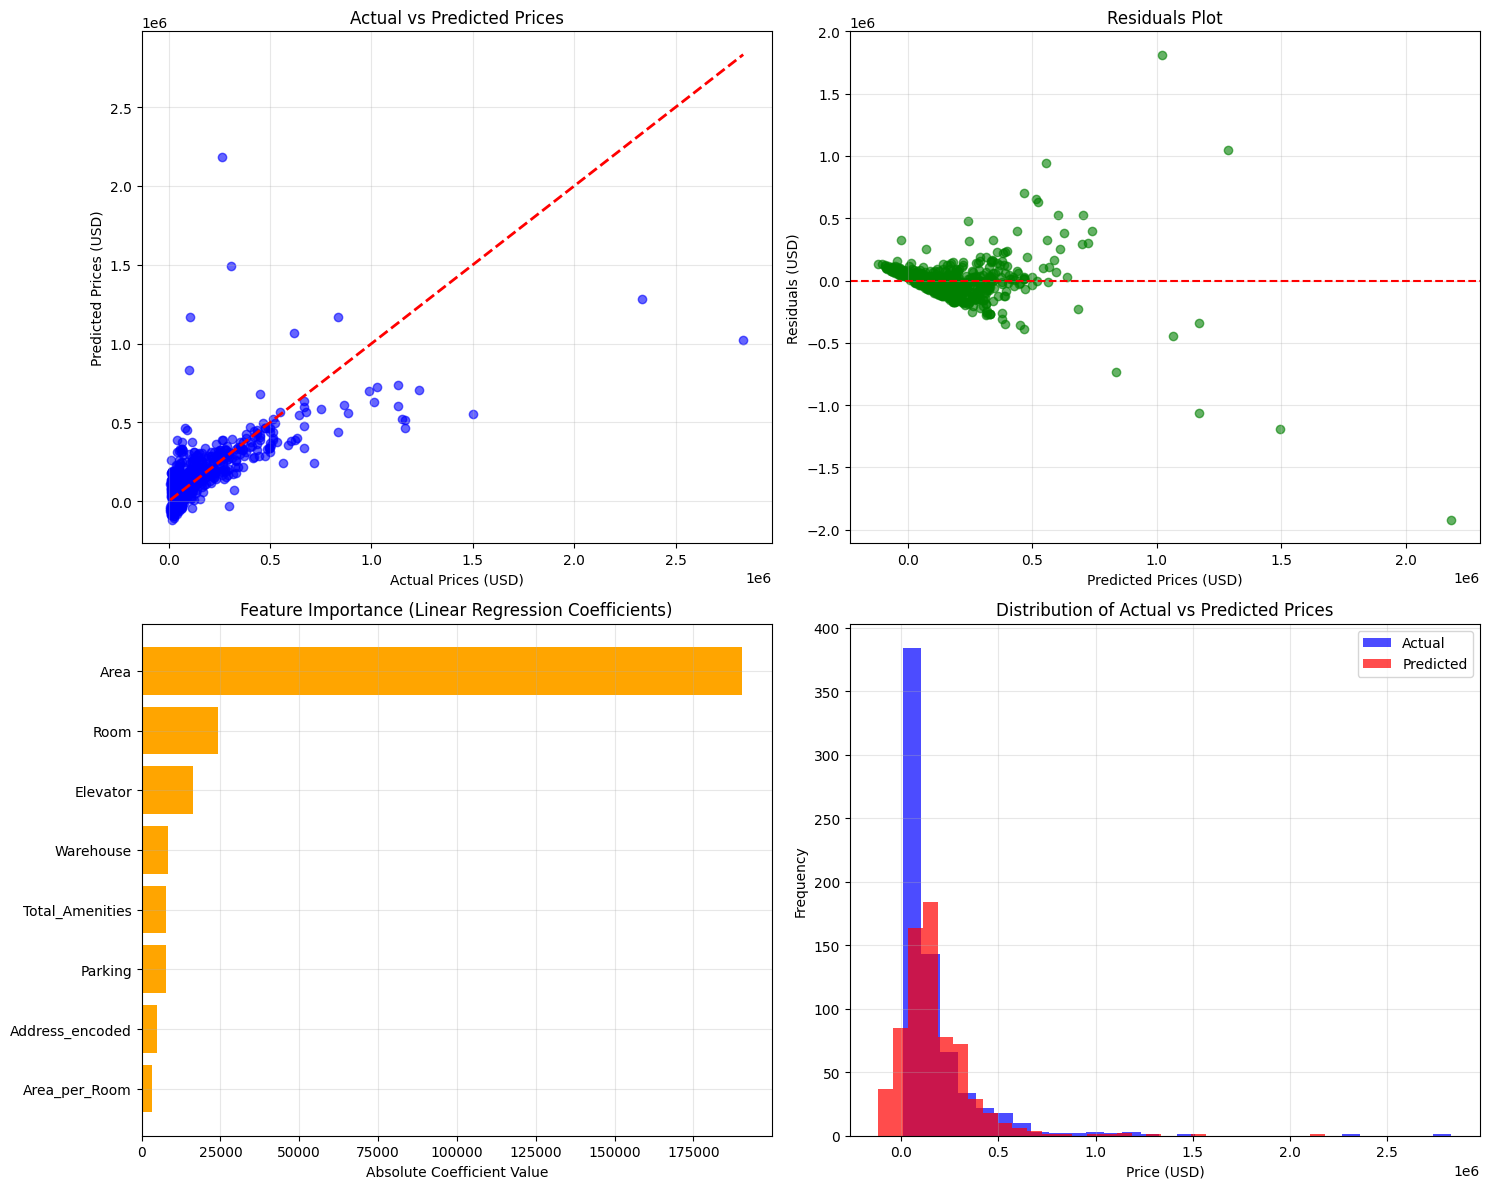

In [62]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Prices (USD)')
axes[0, 0].set_ylabel('Predicted Prices (USD)')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Prices (USD)')
axes[0, 1].set_ylabel('Residuals (USD)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (coefficients)
feature_importance_abs = feature_importance.copy()
feature_importance_abs['Coefficient'] = feature_importance_abs['Coefficient'].abs()
feature_importance_abs = feature_importance_abs.sort_values('Coefficient', ascending=True)

axes[1, 0].barh(feature_importance_abs['Feature'], feature_importance_abs['Coefficient'], color='orange')
axes[1, 0].set_xlabel('Absolute Coefficient Value')
axes[1, 0].set_title('Feature Importance (Linear Regression Coefficients)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Price distribution
axes[1, 1].hist(y_test, bins=30, alpha=0.7, label='Actual', color='blue')
axes[1, 1].hist(y_test_pred, bins=30, alpha=0.7, label='Predicted', color='red')
axes[1, 1].set_xlabel('Price (USD)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Actual vs Predicted Prices')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

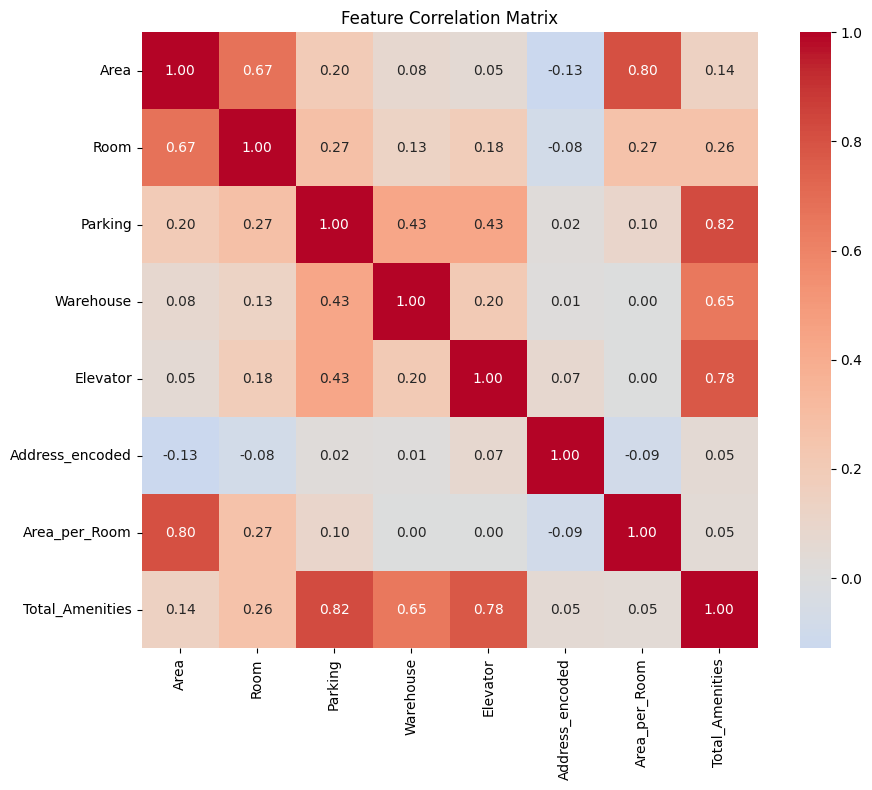

Correlation matrix interpretation:
- Values close to 1 or -1 indicate strong correlation
- Values close to 0 indicate weak correlation
- Strong correlations between features might indicate multicollinearity


In [63]:
# Additional visualization - correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation matrix interpretation:")
print("- Values close to 1 or -1 indicate strong correlation")
print("- Values close to 0 indicate weak correlation")
print("- Strong correlations between features might indicate multicollinearity")

## Summary and Conclusions

Let's summarize what we've accomplished and learned from our linear regression model:

### Model Performance Summary:
- **R² Score**: Indicates the percentage of variance in housing prices explained by our features
- **RMSE**: Root Mean Square Error - average prediction error in USD
- **MAE**: Mean Absolute Error - average absolute prediction error in USD

### Key Findings:
1. **Feature Importance**: The model coefficients show which features have the strongest impact on housing prices
2. **Prediction Accuracy**: The actual vs predicted plot shows how well our model performs
3. **Residuals Analysis**: The residuals plot helps identify any patterns in prediction errors

### Next Steps for Improvement:
- Try polynomial features
- Experiment with other algorithms (Random Forest, Gradient Boosting)
- Handle outliers more effectively
- Consider regularization techniques (Ridge, Lasso)

## Model Improvement Techniques

Let's implement several advanced techniques to improve our model performance:
1. **Advanced Feature Engineering** - Polynomial features and interactions
2. **Outlier Detection & Removal** - Clean extreme outliers  
3. **Advanced Algorithms** - Ridge, Lasso, Random Forest
4. **Feature Selection** - Keep only the most important features
5. **Data Transformation** - Log transformations for better distributions

In [64]:
# Import additional libraries for advanced techniques
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Advanced libraries imported successfully")

Advanced libraries imported successfully


### Step 1: Outlier Detection and Removal

First, let's identify and remove extreme outliers that might be hurting our model's performance.

In [65]:
# Create improved dataset by removing outliers
df_improved = df_model.copy()

# Remove price outliers using IQR method
Q1 = df_improved['Price(USD)'].quantile(0.25)
Q3 = df_improved['Price(USD)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Original dataset size: {len(df_improved)}")
print(f"Price range before outlier removal: ${df_improved['Price(USD)'].min():,.0f} - ${df_improved['Price(USD)'].max():,.0f}")

# Remove extreme price outliers
df_improved = df_improved[(df_improved['Price(USD)'] >= lower_bound) & 
                         (df_improved['Price(USD)'] <= upper_bound)]

print(f"Dataset size after outlier removal: {len(df_improved)}")
print(f"Price range after outlier removal: ${df_improved['Price(USD)'].min():,.0f} - ${df_improved['Price(USD)'].max():,.0f}")
print(f"Removed {len(df_model) - len(df_improved)} outlier samples ({((len(df_model) - len(df_improved))/len(df_model)*100):.1f}%)")

# Also remove area outliers
area_Q1 = df_improved['Area'].quantile(0.05)  # Use more conservative bounds
area_Q3 = df_improved['Area'].quantile(0.95)
df_improved = df_improved[(df_improved['Area'] >= area_Q1) & 
                         (df_improved['Area'] <= area_Q3)]

print(f"Final dataset size after area outlier removal: {len(df_improved)}")
print(f"Total samples removed: {len(df_model) - len(df_improved)} ({((len(df_model) - len(df_improved))/len(df_model)*100):.1f}%)")

Original dataset size: 3479
Price range before outlier removal: $120 - $3,080,000
Dataset size after outlier removal: 3169
Price range after outlier removal: $120 - $428,333
Removed 310 outlier samples (8.9%)
Final dataset size after area outlier removal: 2879
Total samples removed: 600 (17.2%)


### Step 2: Advanced Feature Engineering

Let's create more sophisticated features including polynomial features and feature interactions.

In [66]:
# Advanced feature engineering
df_enhanced = df_improved.copy()

# Log transformation for price (target) - often helps with skewed data
df_enhanced['Log_Price'] = np.log1p(df_enhanced['Price(USD)'])

# Create more advanced features
df_enhanced['Area_squared'] = df_enhanced['Area'] ** 2
df_enhanced['Area_Room_interaction'] = df_enhanced['Area'] * df_enhanced['Room']
df_enhanced['Luxury_score'] = (df_enhanced['Area'] / 100) * df_enhanced['Total_Amenities']
df_enhanced['Area_efficiency'] = df_enhanced['Area'] / (df_enhanced['Room'] + 1)
df_enhanced['Premium_location'] = (df_enhanced['Address_encoded'] > df_enhanced['Address_encoded'].median()).astype(int)

# Room categories - sometimes categorical approach works better than continuous
df_enhanced['Room_category'] = pd.cut(df_enhanced['Room'], 
                                     bins=[0, 1, 2, 3, 10], 
                                     labels=[0, 1, 2, 3], 
                                     include_lowest=True).astype(int)

# Area categories
df_enhanced['Area_category'] = pd.cut(df_enhanced['Area'], 
                                     bins=[0, 70, 100, 150, 1000], 
                                     labels=[0, 1, 2, 3], 
                                     include_lowest=True).astype(int)

print("Advanced features:")
new_features = ['Area_squared', 'Area_Room_interaction', 'Luxury_score', 
                'Area_efficiency', 'Premium_location', 'Room_category', 'Area_category']
for feat in new_features:
    print(f"  {feat}: min={df_enhanced[feat].min():.2f}, max={df_enhanced[feat].max():.2f}")

print(f"\nTotal features now: {len(df_enhanced.columns)}")

Advanced features:
  Area_squared: min=2304.00, max=24025.00
  Area_Room_interaction: min=0.00, max=750.00
  Luxury_score: min=0.00, max=4.65
  Area_efficiency: min=9.67, max=110.00
  Premium_location: min=0.00, max=1.00
  Room_category: min=0.00, max=3.00
  Area_category: min=0.00, max=3.00

Total features now: 19


### Step 3: Prepare Enhanced Dataset and Test Multiple Algorithms

Now let's prepare our enhanced feature set and test multiple advanced algorithms.

In [67]:
# Prepare enhanced feature set
enhanced_features = [
    'Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address_encoded',
    'Area_per_Room', 'Total_Amenities', 'Area_squared', 'Area_Room_interaction', 
    'Luxury_score', 'Area_efficiency', 'Premium_location', 'Room_category', 'Area_category'
]

X_enhanced = df_enhanced[enhanced_features]
y_enhanced = df_enhanced['Price(USD)']
y_log = df_enhanced['Log_Price']  # Log-transformed target

print(f"Enhanced feature set shape: {X_enhanced.shape}")
print(f"Target variables: Price(USD) and Log_Price")

# Split the enhanced dataset
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Also split log-transformed target
_, _, y_train_log, y_test_log = train_test_split(
    X_enhanced, y_log, test_size=0.2, random_state=42
)

# Scale features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print(f"Enhanced training set: {X_train_enh_scaled.shape}")
print(f"Enhanced test set: {X_test_enh_scaled.shape}")

# Check for any remaining NaN values
print(f"NaN values in enhanced features: {np.isnan(X_train_enh_scaled).sum()}")

Enhanced feature set shape: (2879, 15)
Target variables: Price(USD) and Log_Price
Enhanced training set: (2303, 15)
Enhanced test set: (576, 15)
NaN values in enhanced features: 0


In [68]:
# Test multiple advanced algorithms
models_advanced = {
    'Enhanced Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42)
}

results_advanced = {}
print("ADVANCED MODEL COMPARISON")
print("=" * 60)

for name, model in models_advanced.items():
    print(f"\nTraining {name}...")
    
    # Use scaled features for linear models, original for tree-based models
    if 'Linear' in name or 'Ridge' in name or 'Lasso' in name:
        model.fit(X_train_enh_scaled, y_train_enh)
        y_pred = model.predict(X_test_enh_scaled)
    else:
        model.fit(X_train_enh, y_train_enh)
        y_pred = model.predict(X_test_enh)
    
    # Calculate metrics
    r2 = r2_score(y_test_enh, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_enh, y_pred))
    mae = mean_absolute_error(y_test_enh, y_pred)
    
    results_advanced[name] = {
        'model': model,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'predictions': y_pred
    }
    
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")

# Find the best model
best_model_name = max(results_advanced.keys(), key=lambda k: results_advanced[k]['r2'])
best_score = results_advanced[best_model_name]['r2']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"Best R² Score: {best_score:.4f}")
print(f"Improvement over baseline: {((best_score - test_r2)/test_r2*100):+.1f}%")
print(f"{'='*60}")

ADVANCED MODEL COMPARISON

Training Enhanced Linear Regression...
  R² Score: 0.4820
  RMSE: $63,830.64
  MAE: $44,597.48

Training Ridge Regression...
  R² Score: 0.4805
  RMSE: $63,925.38
  MAE: $44,769.33

Training Lasso Regression...
  R² Score: 0.4820
  RMSE: $63,831.87
  MAE: $44,601.31

Training Random Forest...
  R² Score: 0.6756
  RMSE: $50,513.02
  MAE: $29,631.02

Training Gradient Boosting...
  R² Score: 0.7489
  RMSE: $44,444.67
  MAE: $25,837.40

BEST MODEL: Gradient Boosting
Best R² Score: 0.7489
Improvement over baseline: +70.4%


### Step 4: Feature Importance Analysis for Best Model

In [69]:
# Feature importance analysis for best model
best_model_obj = results_advanced[best_model_name]['model']

print(f"FEATURE IMPORTANCE ANALYSIS - {best_model_name}")
print("=" * 60)

if hasattr(best_model_obj, 'feature_importances_'):
    # Tree-based model
    importances = best_model_obj.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': enhanced_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_imp_df.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['Feature']:<20}: {row['Importance']:.4f}")
        
elif hasattr(best_model_obj, 'coef_'):
    # Linear model
    coefficients = best_model_obj.coef_
    feature_imp_df = pd.DataFrame({
        'Feature': enhanced_features,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("Top 10 Most Important Features (by absolute coefficient):")
    for i, (_, row) in enumerate(feature_imp_df.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['Feature']:<20}: {row['Coefficient']:>10.2f}")

# Performance comparison visualization
print(f"\nPERFORMANCE COMPARISON:")
print("-" * 40)
print(f"{'Model':<25} {'R² Score':<12} {'RMSE':<15} {'MAE'}")
print("-" * 65)
for name, result in results_advanced.items():
    print(f"{name:<25} {result['r2']:<12.4f} ${result['rmse']:<14,.0f} ${result['mae']:,.0f}")

# Show improvement over original model
original_r2 = test_r2  # From the original linear regression
improvement = ((best_score - original_r2) / original_r2) * 100
print(f"\nPERFORMANCE IMPROVEMENT:")
print(f"   Original Linear Regression R²: {original_r2:.4f}")
print(f"   Best Enhanced Model R²: {best_score:.4f}")
print(f"   Relative Improvement: {improvement:+.1f}%")

FEATURE IMPORTANCE ANALYSIS - Gradient Boosting
Top 10 Most Important Features:
   1. Luxury_score        : 0.4207
   2. Address_encoded     : 0.3699
   3. Area_squared        : 0.0608
   4. Area                : 0.0525
   5. Area_per_Room       : 0.0254
   6. Premium_location    : 0.0224
   7. Area_Room_interaction: 0.0182
   8. Area_efficiency     : 0.0169
   9. Parking             : 0.0059
  10. Total_Amenities     : 0.0019

PERFORMANCE COMPARISON:
----------------------------------------
Model                     R² Score     RMSE            MAE
-----------------------------------------------------------------
Enhanced Linear Regression 0.4820       $63,831         $44,597
Ridge Regression          0.4805       $63,925         $44,769
Lasso Regression          0.4820       $63,832         $44,601
Random Forest             0.6756       $50,513         $29,631
Gradient Boosting         0.7489       $44,445         $25,837

PERFORMANCE IMPROVEMENT:
   Original Linear Regression R²: 0.

### Step 5: Visualize Improved Model Performance

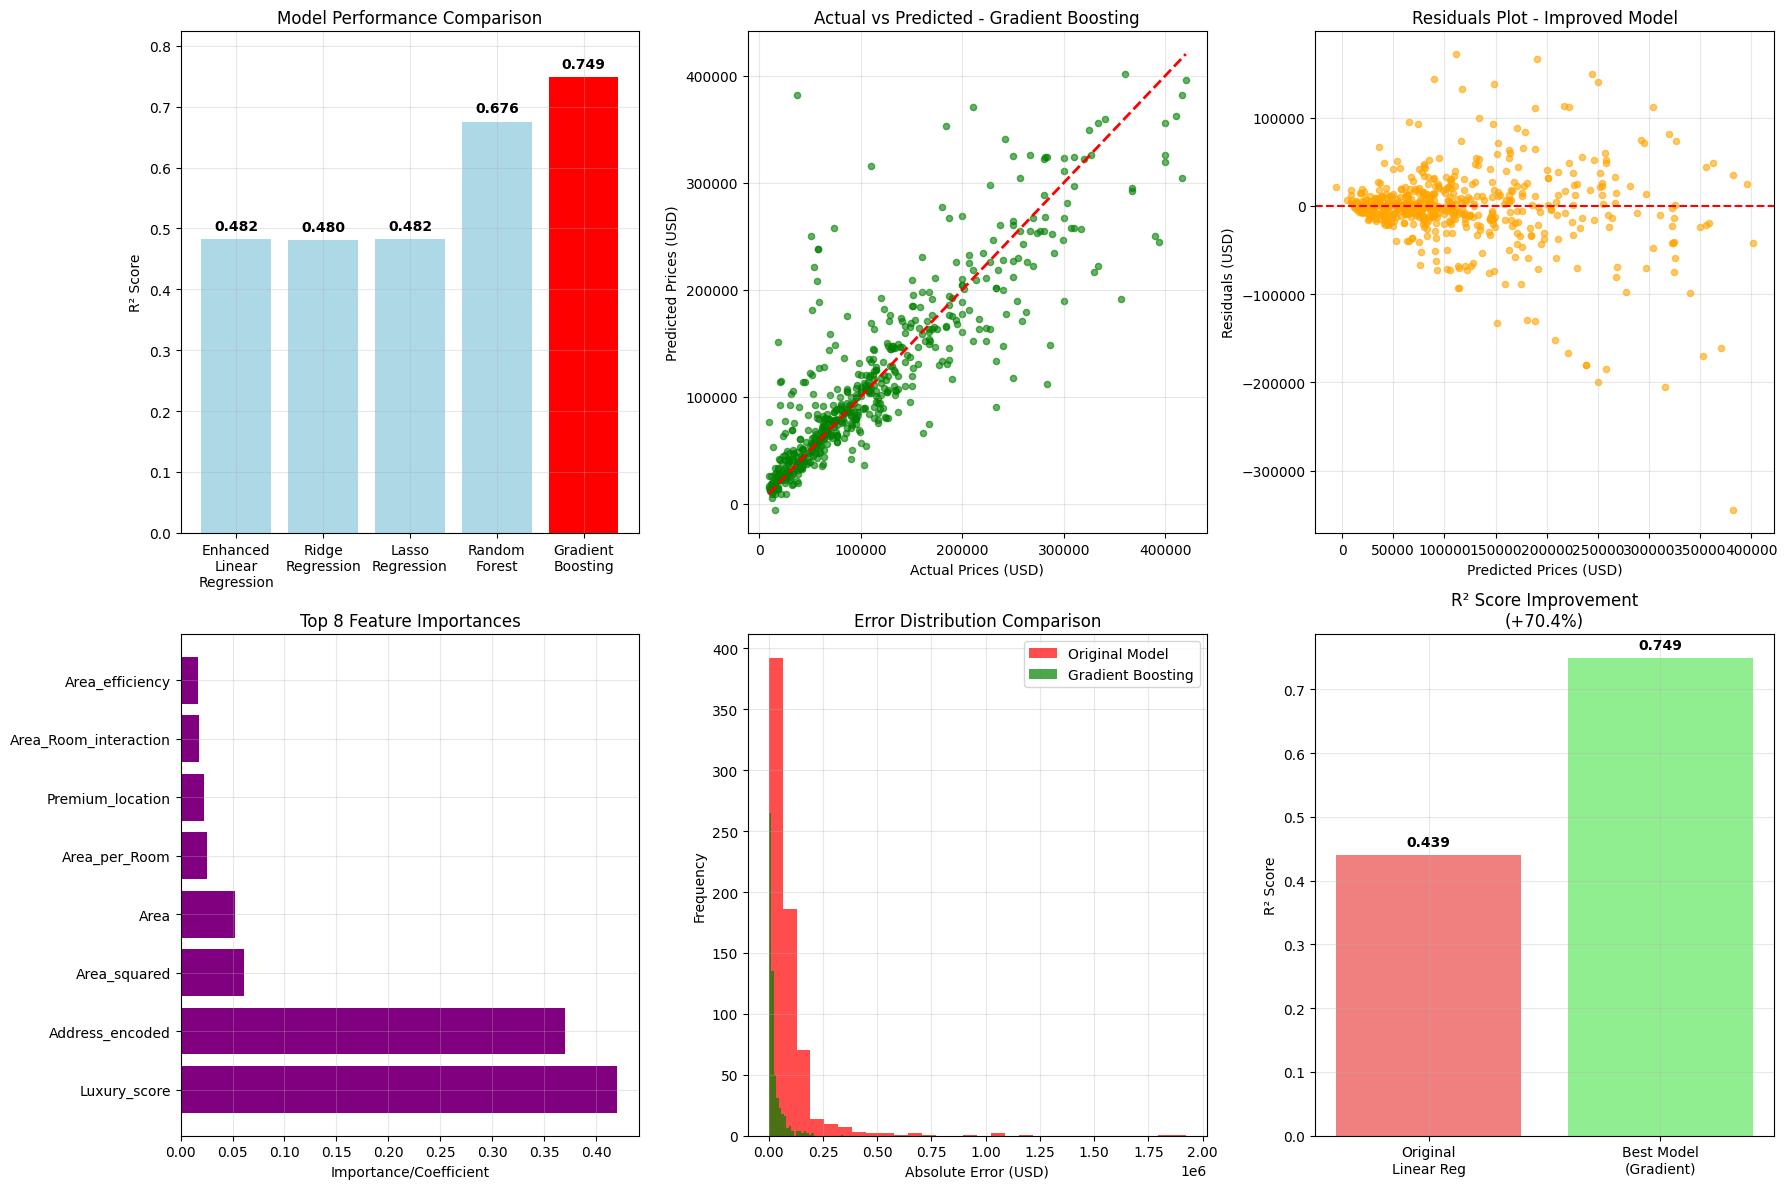


MODEL IMPROVEMENT SUMMARY:
Model performance improved by +70.4%
From R² = 0.4394 to R² = 0.7489


In [70]:
# Create comparison visualizations
best_predictions = results_advanced[best_model_name]['predictions']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Performance Comparison
model_names = list(results_advanced.keys())
r2_scores = [results_advanced[name]['r2'] for name in model_names]

axes[0, 0].bar(range(len(model_names)), r2_scores, color=['red' if name == best_model_name else 'lightblue' for name in model_names])
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0, ha='center')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, max(r2_scores) * 1.1)

# Add R² values on bars
for i, score in enumerate(r2_scores):
    axes[0, 0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Actual vs Predicted (Improved Model)
axes[0, 1].scatter(y_test_enh, best_predictions, alpha=0.6, color='green', s=20)
axes[0, 1].plot([y_test_enh.min(), y_test_enh.max()], [y_test_enh.min(), y_test_enh.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Prices (USD)')
axes[0, 1].set_ylabel('Predicted Prices (USD)')
axes[0, 1].set_title(f'Actual vs Predicted - {best_model_name}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Plot (Improved Model)
residuals_improved = y_test_enh - best_predictions
axes[0, 2].scatter(best_predictions, residuals_improved, alpha=0.6, color='orange', s=20)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Prices (USD)')
axes[0, 2].set_ylabel('Residuals (USD)')
axes[0, 2].set_title('Residuals Plot - Improved Model')
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature Importance (if available)
if 'feature_imp_df' in locals():
    top_features = feature_imp_df.head(8)
    if 'Importance' in feature_imp_df.columns:
        values = top_features['Importance']
        title = 'Top 8 Feature Importances'
    else:
        values = top_features['Abs_Coefficient']
        title = 'Top 8 Feature Coefficients (Absolute)'
    
    axes[1, 0].barh(range(len(top_features)), values, color='purple')
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['Feature'])
    axes[1, 0].set_xlabel('Importance/Coefficient')
    axes[1, 0].set_title(title)
    axes[1, 0].grid(True, alpha=0.3)

# 5. Error Distribution Comparison
axes[1, 1].hist(np.abs(y_test - y_test_pred), bins=30, alpha=0.7, label='Original Model', color='red')
axes[1, 1].hist(np.abs(residuals_improved), bins=30, alpha=0.7, label=f'{best_model_name}', color='green')
axes[1, 1].set_xlabel('Absolute Error (USD)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Error Distribution Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. R² Score Improvement
original_r2 = test_r2
improved_r2 = best_score
improvement_pct = ((improved_r2 - original_r2) / original_r2) * 100

axes[1, 2].bar(['Original\nLinear Reg', f'Best Model\n({best_model_name.split()[0]})'], 
               [original_r2, improved_r2], 
               color=['lightcoral', 'lightgreen'])
axes[1, 2].set_ylabel('R² Score')
axes[1, 2].set_title(f'R² Score Improvement\n(+{improvement_pct:.1f}%)')
axes[1, 2].grid(True, alpha=0.3)

# Add values on bars
axes[1, 2].text(0, original_r2 + 0.01, f'{original_r2:.3f}', ha='center', va='bottom', fontweight='bold')
axes[1, 2].text(1, improved_r2 + 0.01, f'{improved_r2:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nMODEL IMPROVEMENT SUMMARY:")
print(f"Model performance improved by {improvement_pct:+.1f}%")
print(f"From R² = {original_r2:.4f} to R² = {improved_r2:.4f}")